In [1]:
with open("/kaggle/input/chembl22/chembl_22_clean_1576904_sorted_std_final.smi") as file_handle:
    
    data = file_handle.readlines()

In [2]:
data[0:10]

['CCO\tCHEMBL545\n',
 'C\tCHEMBL17564\n',
 'CO\tCHEMBL14688\n',
 'NCCS\tCHEMBL602\n',
 'NCCN\tCHEMBL816\n',
 'CN\tCHEMBL43280\n',
 'C=O\tCHEMBL1255\n',
 'CCN\tCHEMBL14449\n',
 'CSC\tCHEMBL15580\n',
 'CBr\tCHEMBL48339\n']

In [3]:
from concurrent.futures import ThreadPoolExecutor
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf
from keras.layers import TextVectorization
from keras.layers import Input, Embedding, LSTM, Attention, Concatenate, Dense
from keras.models import Model,Sequential
from keras.utils import to_categorical

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
tf.__version__

'2.13.0'

In [6]:
os.cpu_count()

4

In [7]:
def preprocess_molecule(smiles_str):
    return "<"+smiles_str.split("\t")[0]+"\n"

In [8]:
with ThreadPoolExecutor(max_workers=os.cpu_count()) as pool:
    data = list(pool.map(preprocess_molecule,data))

In [11]:
data[0:10]

['<CCO\n',
 '<C\n',
 '<CO\n',
 '<NCCS\n',
 '<NCCN\n',
 '<CN\n',
 '<C=O\n',
 '<CCN\n',
 '<CSC\n',
 '<CBr\n']

In [12]:
def convert_to_source_str(molecule_str):
    return molecule_str.strip("\n")

In [13]:
with ThreadPoolExecutor(max_workers=os.cpu_count()) as pool:
    X = list(pool.map(convert_to_source_str,data))

In [14]:
X[:10]

['<CCO', '<C', '<CO', '<NCCS', '<NCCN', '<CN', '<C=O', '<CCN', '<CSC', '<CBr']

In [16]:
def convert_to_dst_str(molecule_str):
    return molecule_str.strip("<")

In [17]:
with ThreadPoolExecutor(max_workers=os.cpu_count()) as pool:
    Y = list(pool.map(convert_to_dst_str,data))

In [18]:
Y[:10]

['CCO\n',
 'C\n',
 'CO\n',
 'NCCS\n',
 'NCCN\n',
 'CN\n',
 'C=O\n',
 'CCN\n',
 'CSC\n',
 'CBr\n']

In [19]:
data = pd.DataFrame(data)
data["X"] = X
data["Y"] = Y

In [20]:
vocabulary = list(set("".join(list(data["X"]))).union(set("".join(list(data["Y"])))))

In [21]:
vocabulary

['s',
 'P',
 '7',
 '.',
 '1',
 '(',
 ']',
 '8',
 'O',
 '-',
 'l',
 'N',
 'H',
 '=',
 '9',
 'F',
 'o',
 '+',
 ')',
 '[',
 '3',
 '2',
 '%',
 'I',
 'p',
 'c',
 '6',
 '<',
 '#',
 '4',
 '\\',
 '5',
 'n',
 '0',
 'C',
 '\n',
 '/',
 'B',
 'S',
 'r']

In [22]:
len_list = list(map(lambda x: len(x),data["X"]))

In [23]:
len_list[:10]

[4, 2, 3, 5, 5, 3, 4, 4, 4, 4]

Text(0, 0.5, 'Frequency')

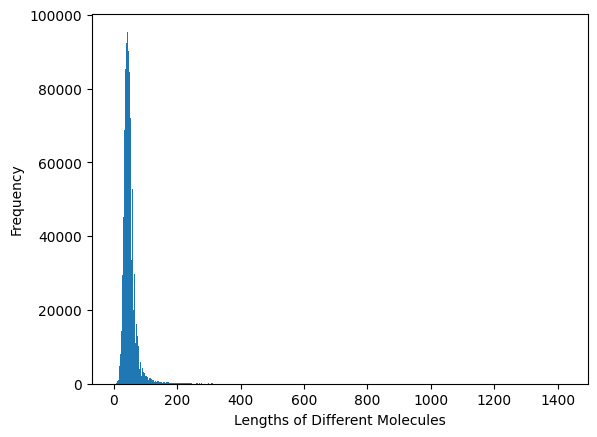

In [25]:
plt.hist(x=len_list,bins=len(set(len_list)))
plt.xlabel("Lengths of Different Molecules")
plt.ylabel("Frequency")

In [26]:
len_hyp_param = 52

In [27]:
filtered_data = data.iloc[np.argwhere(np.array(len_list) <= len_hyp_param)[:,0]]

In [28]:
filtered_data.head()

,0,X,Y
0,<CCO\n,<CCO,CCO\n
1,<C\n,<C,C\n
2,<CO\n,<CO,CO\n
3,<NCCS\n,<NCCS,NCCS\n
4,<NCCN\n,<NCCN,NCCN\n


In [31]:
filtered_data.iloc[0:1000000,:].to_csv("train.csv",index=False)
filtered_data.iloc[1000000:,:].to_csv("test.csv",index=False)

In [32]:
max_input_sequence_len = len(max(list(filtered_data["X"]),key=len))
max_output_sequence_len = len(max(list(filtered_data["Y"]),key=len))

In [33]:
input_text_vectorization_layer = TextVectorization(max_tokens=len(vocabulary)+2,standardize=None,
                                            split="character",
                                            output_sequence_length=max_input_sequence_len,
                                            vocabulary=vocabulary)

In [34]:
output_text_vectorization_layer = TextVectorization(max_tokens=len(vocabulary)+2,standardize=None,
                                                   split="character",
                                                   output_sequence_length=max_output_sequence_len,
                                                   vocabulary=vocabulary)

In [35]:
input_vocabulary = input_text_vectorization_layer.get_vocabulary()

In [36]:
input_vocabulary

['',
 '[UNK]',
 's',
 'P',
 '7',
 '.',
 '1',
 '(',
 ']',
 '8',
 'O',
 '-',
 'l',
 'N',
 'H',
 '=',
 '9',
 'F',
 'o',
 '+',
 ')',
 '[',
 '3',
 '2',
 '%',
 'I',
 'p',
 'c',
 '6',
 '<',
 '#',
 '4',
 '\\',
 '5',
 'n',
 '0',
 'C',
 '\n',
 '/',
 'B',
 'S',
 'r']

In [37]:
output_vocabulary = output_text_vectorization_layer.get_vocabulary()

In [38]:
output_vocabulary

['',
 '[UNK]',
 's',
 'P',
 '7',
 '.',
 '1',
 '(',
 ']',
 '8',
 'O',
 '-',
 'l',
 'N',
 'H',
 '=',
 '9',
 'F',
 'o',
 '+',
 ')',
 '[',
 '3',
 '2',
 '%',
 'I',
 'p',
 'c',
 '6',
 '<',
 '#',
 '4',
 '\\',
 '5',
 'n',
 '0',
 'C',
 '\n',
 '/',
 'B',
 'S',
 'r']

In [39]:
X = input_text_vectorization_layer(filtered_data["X"]).numpy()

In [40]:
Y = output_text_vectorization_layer(filtered_data["Y"]).numpy()

In [41]:
X_train = X[0:1000000]
Y_train = Y[0:1000000]

X_cv = X[1000000:]
Y_cv = Y[1000000:]

In [42]:
X_cv.shape[1]

52

In [43]:
def encoder_decoder_with_attn_mech():
    
    enc_input = Input(shape=(None,),name="input_to_encoder")
    enc_embedding = Embedding(input_dim=len(vocabulary)+2,
                              output_dim=(len(vocabulary)+2)//2,
                              input_length=max_input_sequence_len,
                              name="encoder_embedding_layer")(enc_input)
    enc_lstm_output,enc_last_hidden_state,enc_last_cell_state = LSTM(units=(len(vocabulary)+2)//2,
                                                       return_state=True, return_sequences=True,
                                                       name="encoder_lstm_layer")(enc_embedding)
    
    
    dec_input = Input(shape=(None,),name="input_to_decoder")
    dec_embedding = Embedding(input_dim=len(vocabulary)+2,
                              output_dim=(len(vocabulary)+2)//2,
                              input_length=max_output_sequence_len,
                              name="decoder_embedding_layer")(dec_input)
    dec_lstm_layer = LSTM(units=(len(vocabulary)+2)//2,return_sequences=True,
                          return_state=True,name="decoder_lstm_layer")
    dec_lstm_output,_,_ = dec_lstm_layer(inputs=dec_embedding,
                                         initial_state=[enc_last_hidden_state,enc_last_cell_state])
    
    
    dec_enc_attn_seq = Attention()([dec_lstm_output,enc_lstm_output])
    dec_dense_input = Concatenate()([dec_lstm_output,dec_enc_attn_seq])
    
    dec_output = Dense(units=len(vocabulary)+2,activation="softmax",
                       name="decoder_output")(dec_dense_input)
    
    
    return Model(inputs=[enc_input,dec_input],outputs=dec_output)

In [44]:
seq2seq_encoder_decoder = encoder_decoder_with_attn_mech()

In [45]:
Y_train = to_categorical(Y_train,num_classes=len(vocabulary)+2)

In [46]:
Y_cv = to_categorical(Y_cv,num_classes=len(vocabulary)+2)

In [47]:
def training_data_generator(mb_size,epochs):
    
    for _ in range(epochs):
    
        for i in range(X_train.shape[0]//mb_size):

            yield [X_train[i*mb_size:(i+1)*mb_size],X_train[i*mb_size:(i+1)*mb_size]],Y_train[i*mb_size:(i+1)*mb_size]

In [48]:
def cv_data_generator(mb_size,epochs):
    
    for _ in range(epochs):
    
        for i in range(X_cv.shape[0]//mb_size):

            yield [X_cv[i*mb_size:(i+1)*mb_size],X_cv[i*mb_size:(i+1)*mb_size]],Y_cv[i*mb_size:(i+1)*mb_size]

In [49]:
seq2seq_encoder_decoder.compile(loss="categorical_crossentropy",metrics=["Accuracy"])

In [50]:
seq2seq_encoder_decoder.fit(training_data_generator(1000,25),epochs=1,steps_per_epoch=10,
                           validation_data=cv_data_generator(1711,25),validation_steps=18)

10/10 [==============================] - 6s 173ms/step - loss: 3.6178 - Accuracy: 0.6183 - val_loss: 3.6971 - val_Accuracy: 0.0021


In [51]:
seq2seq_encoder_decoder.save("enc_dec_drug_molecule_gen.keras")

In [52]:
our_model = tf.keras.models.load_model("/kaggle/working/enc_dec_drug_molecule_gen.keras")

In [53]:
def inference_encoder():

    enc_input = our_model.input[0]
    enc_embedding = our_model.layers[2](enc_input)
    enc_lstm_layer = our_model.layers[4]
    enc_lstm_output,enc_last_hidden_state,enc_last_cell_state = enc_lstm_layer(inputs=enc_embedding)
    
    inf_enc = Model(inputs=enc_input,outputs=[enc_lstm_output,enc_last_hidden_state,enc_last_cell_state])
    return inf_enc

In [54]:
def inference_decoder():
    
    dec_input = our_model.input[1]
    another_dec_input = Input(shape=(max_input_sequence_len,(len(vocabulary)+2)//2))
    dec_initial_hidden_state = Input(shape=((len(vocabulary)+2)//2,))
    dec_initial_cell_state = Input(shape=((len(vocabulary)+2)//2,)) 
    dec_embedding = our_model.layers[3](dec_input)
    dec_lstm_layer = our_model.layers[5]
    dec_lstm_output,dec_last_hidden_state,dec_last_cell_state = dec_lstm_layer(inputs=dec_embedding,
                                         initial_state=[dec_initial_hidden_state,dec_initial_cell_state])
    dec_enc_attn_seq = our_model.layers[6]([dec_lstm_output,another_dec_input])
    dec_dense_input = our_model.layers[7]([dec_lstm_output,dec_enc_attn_seq])
    dec_output = our_model.layers[8](dec_dense_input)

    inf_dec = Model(inputs=[dec_input,another_dec_input,dec_initial_hidden_state,dec_initial_cell_state],
               outputs=[dec_output,dec_last_hidden_state,dec_last_cell_state])
    
    return inf_dec

In [63]:
X_cv.shape


(30798, 52)

In [64]:
X_cv.size

1601496

In [65]:
X_cv[0:11,]

array([[29, 36, 36,  6, 23, 36, 36, 36, 36,  7, 36, 15, 13, 13, 27, 22,
        27,  7, 17, 20, 27,  7, 17, 20, 27, 27,  7, 17, 20, 27, 22, 17,
        20, 15, 36,  6, 36,  7, 15, 10, 20, 10, 36, 23, 27,  6, 27, 27,
        18, 27,  6,  0],
       [29, 36, 36, 36,  7, 13, 36,  7, 36, 36,  7, 36, 20, 36, 20, 36,
         7, 15, 10, 20, 13, 36,  6, 36, 36, 36, 36, 13,  7, 36, 20, 36,
        36, 36, 36, 36, 13, 36,  6, 15, 10, 20,  3,  7, 10, 20,  7, 10,
        20, 15, 10,  0],
       [29, 36, 36,  7, 13, 36,  7, 15, 10, 20, 27,  6, 27, 27,  7, 27,
         7, 36, 20, 27,  7, 27,  6, 20, 13,  7, 15, 10, 20, 15, 10, 20,
        13,  7, 15, 10, 20, 15, 10, 20, 27,  6, 27, 27, 27,  7, 36, 20,
        27, 27,  6,  0],
       [29, 36, 36,  7, 13, 36,  7, 15, 10, 20, 27,  6, 27, 27,  7, 27,
         7, 36, 20, 27,  7, 27,  6, 20, 13,  7, 15, 10, 20, 15, 10, 20,
        13,  7, 15, 10, 20, 15, 10, 20, 27,  6, 27, 27, 27,  7, 17, 20,
        27, 27,  6,  0],
       [29, 36, 12, 27,  6, 34, 27, 

In [79]:
X_cv[0:,]

array([[29, 36, 36, ..., 27,  6,  0],
       [29, 36, 36, ..., 15, 10,  0],
       [29, 36, 36, ..., 27,  6,  0],
       ...,
       [29, 36, 10, ...,  0,  0,  0],
       [29, 36, 34, ...,  0,  0,  0],
       [29, 36, 13, ..., 27, 34,  6]])

In [67]:
p = X_cv[0,:].reshape(1,X_cv.shape[1])

In [68]:
p.size

52

In [84]:
def generate_molecules(enc_inp_sequence,batch_size):
    
    inf_enc = inference_encoder()
    states = inf_enc.predict(enc_inp_sequence)
    #print("state =",states[0])
    enc_output = states[0]
    states.pop(0)
    gen_sequence = np.array([[input_vocabulary.index("<")]*batch_size])
    print("gen_sequence = ", gen_sequence)
    stop_generation = False
    generated_molecule = str()
    
    inf_dec = inference_decoder()
    
    while not stop_generation:
        
        dec_output,dec_last_hidden_state,dec_last_cell_state = inf_dec.predict([gen_sequence,enc_output]+states)
        
        print(np.argmax(dec_output[0,-1,:]))
        nxt_gen_char_idx = np.argmax(dec_output[0,-1,:])
        nxt_gen_char = output_vocabulary[nxt_gen_char_idx]
        generated_molecule += nxt_gen_char
        
        if (nxt_gen_char == "\n") or (len(generated_molecule) == max_output_sequence_len):
            stop_generation = True
            
        gen_sequence = np.array([[nxt_gen_char_idx]*batch_size])
        
        states = [dec_last_hidden_state,dec_last_cell_state]
        
    return generated_molecule

In [85]:
generate_molecules(X_cv[0,:].reshape(1,X_cv.shape[1]),1)

1/1 [==============================] - 0s 355ms/step
gen_sequence =  [[29]]
1/1 [==============================] - 0s 380ms/step
0
1/1 [==============================] - 0s 22ms/step
0
1/1 [==============================] - 0s 22ms/step
0
1/1 [==============================] - 0s 22ms/step
0
1/1 [==============================] - 0s 21ms/step
0
1/1 [==============================] - 0s 23ms/step
0
1/1 [==============================] - 0s 24ms/step
0
1/1 [==============================] - 0s 24ms/step
0
1/1 [==============================] - 0s 23ms/step
0
1/1 [==============================] - 0s 24ms/step
0
1/1 [==============================] - 0s 23ms/step
0
1/1 [==============================] - 0s 22ms/step
0
1/1 [==============================] - 0s 24ms/step
0
1/1 [==============================] - 0s 25ms/step
0
1/1 [==============================] - 0s 23ms/step
0
1/1 [==============================] - 0s 21ms/step
0
1/1 [==============================] - 0s 22ms/step
0
1/1 [

KeyboardInterrupt: 